# Computer Vision - P5

### **Carefully read the file `README.md` as well as the following instructions before start coding.**

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): December 11th, 23:00 h** 

==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.



 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [2]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io, exposure
import os

import matplotlib.pyplot as plt

In [3]:
path = "./images/texturesimages/buildings/"
building_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/forest/"
forest_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

path = "./images/texturesimages/sunset/"
sunset_images = [skimage.io.imread(path + f) for f in os.listdir(path)]

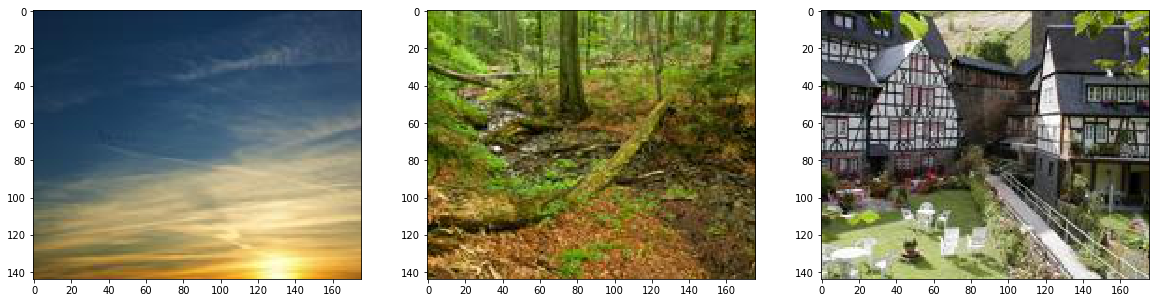

In [4]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(sunset_images[0])
ax[1].imshow(forest_images[0])
ax[2].imshow(building_images[0])
plt.show()

In [5]:
len(sunset_images), len(forest_images), len(sunset_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [6]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [ ]:
# The filters are loaded and their shape is printed
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

### Plotting all filters

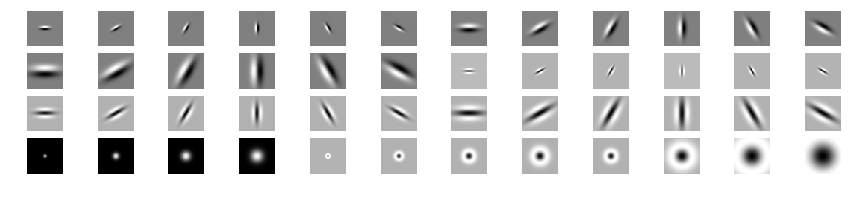

In [8]:
# The number of filters is obtaied
n_filters = filter_bank.shape[-1]

# The subplots are created
fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

# k = 0
# All the filters are shown in the subplot created
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,i*12 + j], cmap = 'gray')
        ax[i,j].axis("off")
        # k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png">


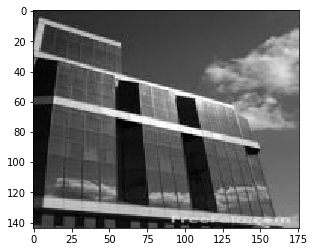

In [9]:
im = building_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

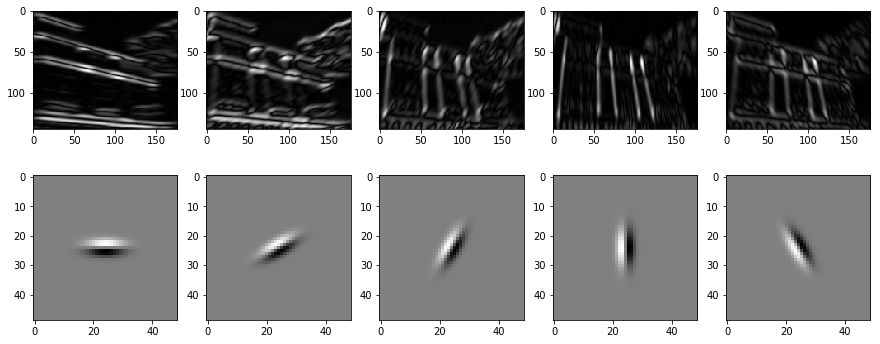

In [10]:
def visualize_features(im,  filter_bank, n_filters=5):
    # The subplots are created
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    
    # For every filter given
    for i in range(n_filters):
        
        # Show the filter
        ax[1,i].imshow(filter_bank[:,:,i], cmap='gray')
        
        # Apply the filter to the image given
        twod_mask = np.abs(scipy.ndimage.convolve(im, filter_bank[:,:,i]))
        
        # Show the resulting image
        ax[0,i].imshow(twod_mask, cmap='gray')
        
visualize_features(im, filter_bank)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [11]:
im = skimage.color.rgb2gray(building_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):
    
    # A zeros matrix is created with the shape of the image
    im_conv = np.zeros(image.shape)
    
    # A zeros vector is created with the length of the number of filters
    features_for_im = np.zeros(n_filters)
    
    # For every fitler
    for i in range(n_filters):
        
        # The filter is applied
        im_conv = scipy.ndimage.convolve(image, filter_bank[:,:,i])
        
        # The mean is calculated and assigned to the vector
        features_for_im[i] = np.mean(np.abs(im_conv))
      
    # The vector is returned
    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [45]:
all_images = building_images + forest_images + sunset_images

In [14]:
%%time

def get_class_features(all_images,  filter_bank):
    
    # The number of images is computed
    n_images = len(all_images)
    
    # The number of filters is computed
    n_filters = filter_bank.shape[-1]
    
    # A zeros matrix is created with the number of images and the number of filters
    all_feature_vectors=np.zeros((n_images,n_filters))
    
    # For every image
    for i in range(n_images):
        
        # The features are calculated
        all_feature_vectors[i] = features_from_filter_bank(skimage.color.rgb2gray(all_images[i]), 
                                                           filter_bank, 
                                                           n_filters)

    # The matrix is returned
    return all_feature_vectors

all_feature_vectors=get_class_features(all_images,  filter_bank)

CPU times: user 9min 28s, sys: 12.3 s, total: 9min 41s
Wall time: 9min 46s


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


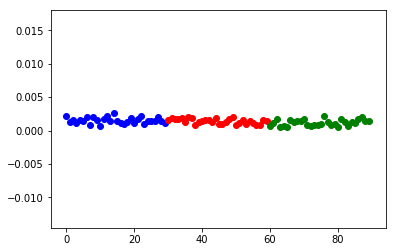

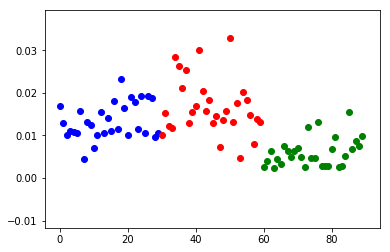

In [46]:
def visualize_features(k, all_feature_vectors):
    
    # The points are plotted with an scatter plot
    plt.scatter([i for i in range(30)], all_feature_vectors[0:30, k], color='blue')
    plt.scatter([i for i in range(30, 60)], all_feature_vectors[30:60, k], color='red')
    plt.scatter([i for i in range(60, 90)], all_feature_vectors[60:90, k], color='green')
    
    # The plot is shown
    plt.show()
    

visualize_features(25, all_feature_vectors)    
visualize_features(3, all_feature_vectors)





#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar and different images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

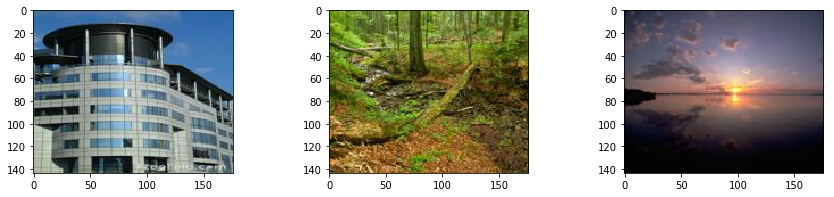

In [47]:
X_filter = np.array(all_feature_vectors)
ind_1 = 6
ind_2 = 30
ind_3 = 65

query_1 = X_filter[6, :]
query_2 = X_filter[30,:]
query_3 = X_filter[65,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[6]) 
ax[1].imshow(all_images[30])
ax[2].imshow(all_images[65])

In [48]:
X_filter.shape

(90, 48)

In [49]:
def retrieve_k_images_from_X_filter(query, X, k):
    
    # The features from the imag entered are calculated
    query_vector = features_from_filter_bank(skimage.color.rgb2gray(query),
                                             filter_bank,
                                             filter_bank.shape[2])
    
    # The distances array is initialized
    distances = []
    
    # For every row in the matrix
    for i in range(X.shape[0]):
        
        # The distance with this row is calculated and appended
        distances.append(np.linalg.norm(query_vector - X[i]))
        
    # The distances are sorted
    sorted_distances = sorted(distances)
    
    # The distances to return array is initialized
    dist_to_return = []
    
    # The indices to return array is initialized
    indices_to_return = []
    
    # For the number of images to return
    for i in range(k):
        
        # Get the index of the ith most similar image
        indices_to_return.append(distances.index(sorted_distances[i]))
        
        # Get the ith most similar image
        dist_to_return.append(sorted_distances[i])
        
    # Return the two arrays
    return indices_to_return, dist_to_return

In [50]:
retrieve_k_images_from_X_filter(all_images[3], X_filter, 5)

([3, 1, 7, 27, 22],
 [0.0,
  0.02448736080140232,
  0.06034575788630375,
  0.060374379587084,
  0.06264013125533176])


## Exercise 5.6 Retrieving the most similar image based on the information about color

Based on exercises 5.3 and 5.4:
1)  Implement a function `get_rgb_Features(all_images)` that obtains the RGB information by applying `exposure.histogram(image,nbins=32)` to get a feature vector for each of the images in the union of the three datasets (forest, buildings, sunset). It must return a matrix containing at row $k$ feature vector for the input image $k$.

2)  Use the same function `retrieve_k_images_from_X(query, X, k)` where `query` is an image, `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar and distant images (according to the l2 norm) and the distances from the closest and the furthest images to the query image. You can include the query image since it is in `X`.

- And again, make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

In [51]:
def get_rgb_Features(all_images):
    
    # The length of all_images is calculated
    n_images = len(all_images)
    
    # A zeros matrix is created
    all_feature_vectors = np.zeros((n_images*3,32))
    
    # For every image
    for i in range(n_images):
        
        # The histogram is computed for every color channel
        all_feature_vectors[3*i] = exposure.histogram(all_images[i][:,:,0]/255,nbins=32)[0]
        all_feature_vectors[3*i + 1] = exposure.histogram(all_images[i][:,:,1]/255,nbins=32)[0]
        all_feature_vectors[3*i + 2] = exposure.histogram(all_images[i][:,:,2]/255,nbins=32)[0]

    # The matrix is returned
    return all_feature_vectors

In [52]:
X_rgb = get_rgb_Features(all_images)

In [53]:
X_rgb

array([[ 239.,  388.,  536., ...,  257.,  186.,  177.],
       [ 210.,  401.,  669., ...,  247.,  150.,  171.],
       [ 760.,  725., 1059., ...,  189.,  145.,  111.],
       ...,
       [3173., 1345.,  907., ...,  806.,  880.,  422.],
       [5591., 1299., 1015., ...,   57.,   16.,   10.],
       [6076., 1352., 1397., ...,   24.,   10.,    7.]])

In [54]:
def retrieve_k_images_from_X_rgb(query, X, k):
    
    # The matrix is initialized
    query_vector = []
    
    # The histogram is added to the matrix with a row for every color
    query_vector.append(exposure.histogram(query[:,:,0]/255,nbins=32)[0])
    query_vector.append(exposure.histogram(query[:,:,1]/255,nbins=32)[0])
    query_vector.append(exposure.histogram(query[:,:,2]/255,nbins=32)[0])
    
    # The distances array is initialized
    distances = []
    
    # For every row in the matrix
    for i in range(int(X.shape[0]/3)):
        
        # The norm of the subtracted matrix is calculated and added to the distances vector
        distances.append(np.linalg.norm(query_vector - X[3*i:3*i+3]))
        
    # The distances are sorted
    sorted_distances = sorted(distances)
    
    # The distances to return array is initialized
    dist_to_return = []
    
    # The indices to return array is initialized
    indices_to_return = []
    
    # For the number of images to return
    for i in range(k):
        
        # Get the index of the ith most similar image
        indices_to_return.append(distances.index(sorted_distances[i]))
        
        # Get the ith most similar image
        dist_to_return.append(sorted_distances[i])
        
    # Return the two arrays
    return indices_to_return, dist_to_return

In [55]:
retrieve_k_images_from_X_rgb(all_images[3], X_rgb, 5)

([3, 23, 27, 10, 14],
 [0.0,
  6003.4758265524815,
  7127.206605676589,
  7634.011265383357,
  7740.4317709027055])

## Exercise 5.7 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.



- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?



In [56]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [57]:
def accuracy_filter(X, class_labels, k, query, class_query):
    
    # The top indices are retrieved
    indices, _ = retrieve_k_images_from_X_filter(query, X, k)
    
    # The counter is initialized
    counter = 0
    
    # For every index
    for i in range(k):
        
        # If it is in the same class
        if class_labels[indices[i]] == class_query:
            
            # Add one to the counter
            counter += 1
            
    # The accuracy is computed and returned
    acc = counter/k
    return acc

def accuracy_rgb(X, class_labels, k, query, class_query):
    
    # The same is done with the images on rgb
    indices, _ = retrieve_k_images_from_X_rgb(query, X, k)
    counter = 0
    for i in range(k):
        if class_labels[indices[i]] == class_query:
            counter += 1
    acc = counter/k
    return acc


In [58]:
print(accuracy_filter(X_filter, class_labels, 10, all_images[3], 0))
print(accuracy_rgb(X_rgb, class_labels, 10, all_images[3], 0))

0.9
0.6


- Compute the accuracy for both cases, when X is obtained by (A) applying the bank of filters or (B) the color information.



- Compare the results obtained. Which descriptors give better performance? Can you explain why?

## Exercise 5.8 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [59]:
def lm_features_rgb(image, filter_bank):
    
    # The number of filters is computed
    n_filters = filter_bank.shape[2]
    
    # A zeros vector is initialized
    features_for_im = np.zeros(3*n_filters)
    
    # The vector is filled with the features
    features_for_im = np.concatenate([features_from_filter_bank(image[:,:,0], filter_bank, n_filters),
                                      features_from_filter_bank(image[:,:,1], filter_bank, n_filters),
                                      features_from_filter_bank(image[:,:,2], filter_bank, n_filters)])
        
    # The vector is returned
    return features_for_im

In [60]:
lm_features = lm_features_rgb(all_images[3], filter_bank)

## Exercise 5.9 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [ ]:
!pip install tqdm 

In [64]:
from tqdm import tqdm_notebook # Module added to track the progress of the for loop

# We had problems qwith the parallel library, so we had to do it the slow way, the estimated time of completion
# is approximately 30 minutes, we have not cleared the output so you are able to see it without executing.

# The number of filters is computed
n_filters = filter_bank.shape[2]

# A zeros matrix is initialized
X_lm_rgb = np.zeros((len(all_images), 3*n_filters))

# For every image
for i in tqdm_notebook(range(len(all_images))):
    
    # The features are computed
    X_lm_rgb[i] = lm_features_rgb(all_images[i], filter_bank)

# The matrix is printed
X_lm_rgb    

array([[101.48208649, 101.0131392 ,  99.56368371, ...,  23.76803188,
          7.20817551,  14.73110006],
       [107.45580808, 106.07165404,  91.27580492, ...,  33.43083176,
         10.27971117,   2.31912879],
       [ 80.39902936,  84.1196733 ,  82.57260101, ...,  39.98429609,
         12.35811237,   2.43509312],
       ...,
       [106.28424874, 100.10779672,  92.7985322 , ...,  19.31297348,
          5.7963226 ,   0.74581755],
       [105.95935922,  97.35681029,  86.06676136, ...,   9.71216067,
          2.73847854,   0.        ],
       [ 96.42660985,  90.85976957,  90.69858744, ...,  14.43655303,
          4.24376578,   2.21216067]])

## 5.10 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

In [65]:
# compute (X_lm_rgb) and cast it as array
X_lm_rgb = np.array(X_lm_rgb)

3
10
23
47


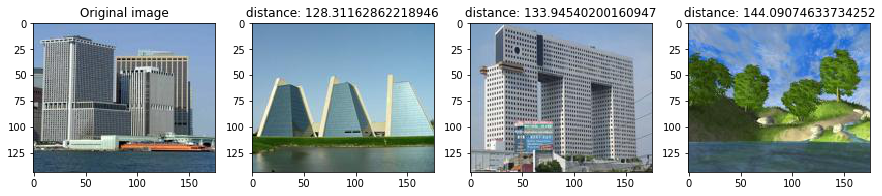

In [72]:
def closest_k_images(image, all_images, X_lm_rgb, filter_bank, k=4):
    
    # The features of the given image are computed
    query = lm_features_rgb(image, filter_bank)
    
    # The distances vector is initialized
    distances = []
    
    # For every row of the X_lm_rgb matrix
    for i in range(len(X_lm_rgb)):
        
        # Add the distance to the query vector previously calculated
        distances.append(np.linalg.norm(query - X_lm_rgb[i]))
    
    # The distances are sorted
    sorted_distances = sorted(distances)
    
    # The distances to return array is initialized
    dist_to_return = []
    
    # The indices to return array is initialized
    indices_to_return = []
    
    # For the number of images to return
    for i in range(k):
        
        # Get the index of the ith most similar image
        indices_to_return.append(distances.index(sorted_distances[i]))
        
        # Get the ith most similar image
        dist_to_return.append(sorted_distances[i])
        
    # The subplots are created
    fig, ax = plt.subplots(ncols=k, nrows=1, figsize=(15,6))
    
    # For every filter given
    for i in range(k):
        # Show the ith image
        ax[i].imshow(all_images[indices_to_return[i]])
        
        if i:
            # Set the title to the ith image
            ax[i].set_title('distance: ' + str(dist_to_return[i]))
            
        else:
            # Set the title to the first image
            ax[i].set_title('Original image')

closest_k_images(all_images[3], all_images, X_lm_rgb, filter_bank)